# Gaussian Mixture Model (Dummy dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# data filenames
data_filename   = './dummy_data_d.csv'
trace_filename  = './traces/trace_dummy'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)   
data_obj.data.head(5)
data = data_obj.data
data.head(5)

,200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,...,392.0,393.0,394.0,395.0,396.0,397.0,398.0,399.0,400.0,label
27,-0.278164,0.004299,0.998228,-0.709271,-0.056314,0.210967,-0.717121,-0.508413,-0.061796,-0.003577,...,-0.452931,0.177823,0.742207,-0.192136,0.149462,-0.465034,0.040191,1.263480,-0.014465,A
15,0.645924,0.188868,0.411685,-0.370543,-0.461943,0.029332,-0.033631,-0.071514,0.286366,-0.281848,...,1.076965,0.550835,0.613505,0.331136,-0.534263,0.097469,-0.116280,0.492744,0.872152,A
23,-0.250480,0.068203,-0.119186,0.537053,-0.966290,-0.552427,0.310381,0.170800,0.114175,-0.383512,...,4.556106,4.235534,4.241795,4.108292,4.434495,2.828799,3.130635,2.382182,1.703694,B
17,-0.274322,0.317443,0.519901,-0.806334,-0.207360,-0.308761,0.745961,0.087207,-0.180280,-0.426745,...,0.808330,0.322626,0.946392,-0.631524,0.002068,0.687065,-0.431604,0.066601,-0.399912,A
8,0.109480,0.453009,0.357092,0.472311,0.004277,-0.040146,0.403554,-0.785452,-0.384583,0.260944,...,-0.454642,-1.041124,0.194845,0.628560,0.133107,-1.100660,0.253049,-0.335544,-0.635210,A


A: blue
B: red


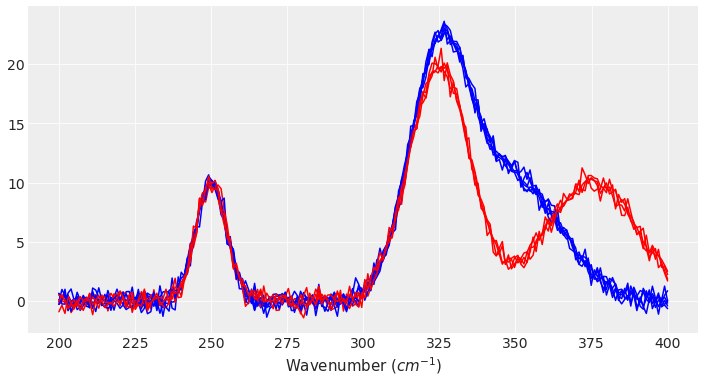

In [5]:
# list of class labels
class_labels = data_obj.get_class_labels()

# number of classes
nclasses = len(class_labels)

# plot dataframe
utl.plot_data(data_obj, 10)

In [6]:
# number of samples from each class
print(data_obj.data[data_obj.label_column].value_counts())

B    15
A    15
Name: label, dtype: int64


# Model definition (Gaussian Mixture)

In [8]:
# store the data for the classes in a list of dataframes
df = [data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

# 1D array of X values
x_val = np.array(data.columns[:data_obj.non_data_columns], dtype='float32').reshape(200,1)

# 2D array containing Y values (observation data)
x_n = data.columns[:data_obj.non_data_columns]
x_s = [df[i][x_n].values for i in range(len(df))]

In [9]:
peaks = [3]
traces = []
models = []

for npeaks in peaks:
    print("training on " + str(npeaks) + " peaks")
    with pm.Model() as model:
        amp = pm.Uniform('amp', 0, x_s[0].max(), shape=(nclasses,npeaks))
        mu = pm.Normal('mu', mu=np.linspace(x_val.min(), x_val.max(), npeaks), sd=50, 
                       shape=(nclasses,npeaks), transform=pm.distributions.transforms.ordered)
        #mu = pm.Normal('mu', mu=x_val.mean(), sd=(x_val.max()-x_val.min())/2, shape=(1,npeaks), 
        #               testval=np.linspace(x_val.min(), x_val.max(), npeaks))
        sigma = pm.HalfNormal('sigma', sd=100, shape=(nclasses,npeaks))
        epsilon = pm.HalfNormal('epsilon', sd=1)

        ya = pm.Deterministic('ya', (amp[0] * np.exp(-(x_val - mu[0])**2/(2 * sigma[0]**2))).sum(axis=1))
        yb = pm.Deterministic('yb', (amp[1] * np.exp(-(x_val - mu[1])**2/(2 * sigma[1]**2))).sum(axis=1))
        
        y_pred_a = pm.Normal('y_pred_a', mu=ya, sd=epsilon, observed=x_s[0])
        y_pred_b = pm.Normal('y_pred_b', mu=yb, sd=epsilon, observed=x_s[1])
        
        traces += [pm.sample(2000, init='adapt_diag', random_seed=42)]
        models += [model]

training on 3 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma, mu, amp]
Sampling 2 chains: 100%|██████████| 5000/5000 [05:41<00:00, 14.65draws/s]
The acceptance probability does not match the target. It is 0.9969457799991949, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9981783230461557, but should be close to 0.8. Try to increase the number of tuning steps.


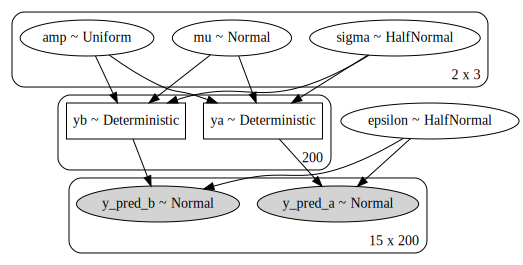

In [10]:
pm.model_to_graphviz(model)

# Model evaluation

In [11]:
varnames = ['amp', 'mu', 'sigma', 'epsilon']
coef = az.summary(traces[0], varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"amp[0,0]",10.049,0.053,9.955,10.149,0.001,0.001,3941.0,3941.0,3956.0,3198.0,1.0
"amp[0,1]",19.829,0.182,19.480,20.160,0.004,0.003,1906.0,1905.0,1901.0,2369.0,1.0
"amp[0,2]",10.082,0.069,9.944,10.207,0.002,0.001,2058.0,2058.0,2054.0,2665.0,1.0
"amp[1,0]",10.034,0.053,9.940,10.139,0.001,0.001,3062.0,3061.0,3071.0,2946.0,1.0
"amp[1,1]",20.046,0.038,19.978,20.118,0.001,0.000,4524.0,4522.0,4543.0,3063.0,1.0
"amp[1,2]",10.013,0.032,9.953,10.074,0.001,0.000,2901.0,2901.0,2908.0,2906.0,1.0
"mu[0,0]",250.017,0.031,249.956,250.072,0.001,0.000,3672.0,3672.0,3685.0,2704.0,1.0
"mu[0,1]",324.912,0.071,324.778,325.042,0.002,0.001,1828.0,1828.0,1827.0,2236.0,1.0
"mu[0,2]",349.787,0.300,349.204,350.332,0.007,0.005,1813.0,1812.0,1803.0,2197.0,1.0
"mu[1,0]",250.068,0.029,250.012,250.120,0.001,0.000,2702.0,2702.0,2709.0,2645.0,1.0


In [12]:
#az.plot_trace(traces[0], varnames, combined=True);
#az.plot_trace(traces[1], varnames);

In [13]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(peaks))]

100%|██████████| 500/500 [00:02<00:00, 216.97it/s]


In [14]:
#data_ppc = az.from_pymc3(trace=trace, posterior_predictive=ppc)
#ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

## Compare distribution of data and posterior samples

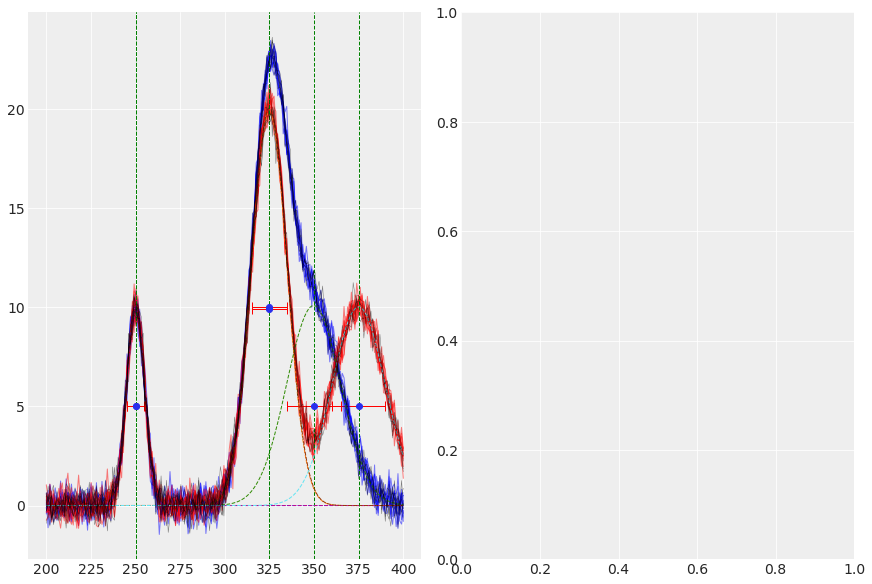

In [19]:
_, ax = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)
ax = np.ravel(ax)
for idx, ppc_x in enumerate(ppc_mm):
    # plot samples from the posterior
    sp = ppc_x['y_pred_a']
    for i in range(10):
        ax[idx].plot(x_val, sp[i,0,:], '-', color="blue", linewidth=1, alpha=.5)
    
    # plot samples from the posterior
    sp = ppc_x['y_pred_b']
    for i in range(10):
        ax[idx].plot(x_val, sp[i,0,:], '-', color="red", linewidth=1, alpha=.5)
    
    # plot mixture components 
    A = traces[idx]['amp'].mean(axis=0).flatten()
    M = traces[idx]['mu'].mean(axis=0).flatten()
    S = traces[idx]['sigma'].mean(axis=0).flatten()
    for j in range(len(A)):
        Y = A[j] * np.exp(-(x_val - M[j])**2/(2 * S[j]**2))
        ax[idx].plot(x_val, Y, '--', linewidth=1)
        ax[idx].axvline(M[j], linestyle='--', linewidth=1, color='g')
        ax[idx].errorbar(x=M[j], y=.5*A[j], xerr=S[j], fmt='o', 
                         ecolor='r', elinewidth=1, capsize=5, capthick=1)
        
    # plot samples from the dataset
    for i in range(10):
        y_val = data.values[i]
        ax[idx].plot(x_val, y_val[:data_obj.non_data_columns], '-', color="black", alpha=.5, linewidth=.5)
        
    # plot the mean of the real data
    #ax[idx].plot(x_val, data_obj.data.iloc[:,:data_obj.non_data_columns].mean(), '--', color='yellow', linewidth=1);
    #ax[idx].set_title('peaks = {}'.format(peaks[idx]))

In [20]:
comp = az.compare(dict(zip(peaks, traces)), method='BB-pseudo-BMA')
comp

TypeError: Data must include log_likelihood in sample_stats

In [21]:
az.plot_compare(comp);

NameError: name 'comp' is not defined

In [23]:
plt.figure(figsize=(8, 3))
data = [x_s]
dd = [ppc_mm[i]['y_pred_a'] for i in range(len(ppc_mm))]
data.extend(dd)
labels = ['real data']
pk = [str(peaks[i]) for i in range(len(peaks))]
labels.extend(pk)
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [2.5, 97.5])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.1, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([]);

AttributeError: 'list' object has no attribute 'mean'

<Figure size 576x216 with 0 Axes>

In [24]:
for idx, trace in enumerate(traces):
    print(str(peaks[idx]) + " peaks, bfmi: " + str(az.bfmi(trace)))

3 peaks, bfmi: [0.92146079 0.93764461]


In [26]:
for idx, ppc in enumerate(ppc_mm):
    print("--- " + str(peaks[idx]) + " peaks -----------\n" + str(az.r2_score(x_s, ppc['y_pred_a'])))

ValueError: operands could not be broadcast together with shapes (2,15,200) (500,15,200) 

In [27]:
varnames = ['amp', 'mu', 'sigma', 'epsilon']
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    coef = az.summary(trace, varnames)
    print(coef)


--- 3 peaks ----------------------------------
               mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
amp[0,0]     10.049  0.053    9.955   10.149      0.001    0.001    3941.0   
amp[0,1]     19.829  0.182   19.480   20.160      0.004    0.003    1906.0   
amp[0,2]     10.082  0.069    9.944   10.207      0.002    0.001    2058.0   
amp[1,0]     10.034  0.053    9.940   10.139      0.001    0.001    3062.0   
amp[1,1]     20.046  0.038   19.978   20.118      0.001    0.000    4524.0   
amp[1,2]     10.013  0.032    9.953   10.074      0.001    0.000    2901.0   
mu[0,0]     250.017  0.031  249.956  250.072      0.001    0.000    3672.0   
mu[0,1]     324.912  0.071  324.778  325.042      0.002    0.001    1828.0   
mu[0,2]     349.787  0.300  349.204  350.332      0.007    0.005    1813.0   
mu[1,0]     250.068  0.029  250.012  250.120      0.001    0.000    2702.0   
mu[1,1]     324.971  0.022  324.930  325.013      0.000    0.000    4465.0   
mu[1,2]     374.


--- 3 peaks ----------------------------------


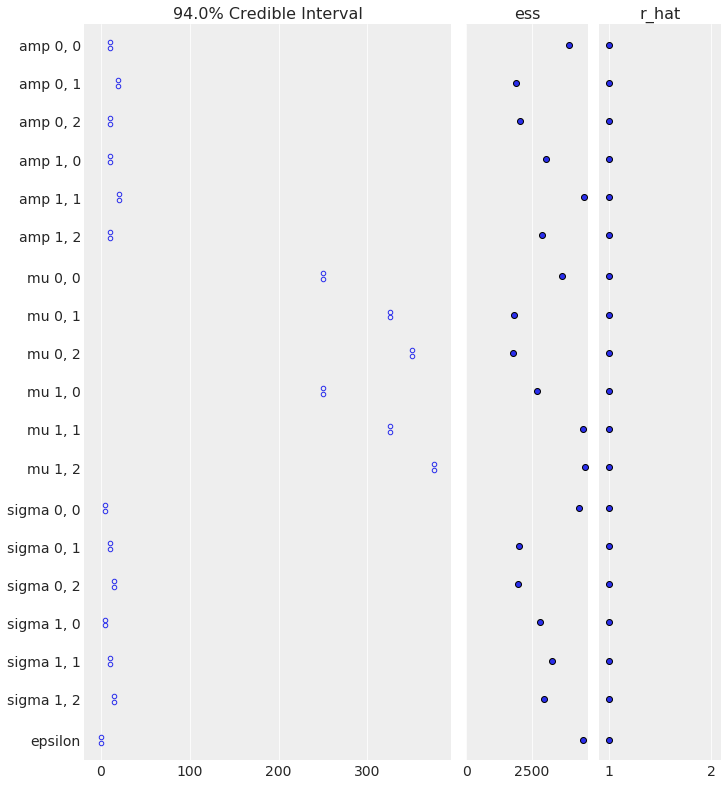

In [28]:
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    az.plot_forest(trace, var_names = ['amp', 'mu', 'sigma', 'epsilon'], r_hat=True, ess=True);